In [60]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [61]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [62]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [63]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite", echo=False)
conn = engine.connect()

In [64]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [65]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [66]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [67]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [68]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [69]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0xbd9ad2ab80>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [70]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [71]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0xbd9418abb0>,
 'longitude': -157.8168,
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'latitude': 21.2716}

# Exploratory Precipitation Analysis

In [72]:
# Find the most recent date in the data set.
last_date= session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date

('2017-08-23')

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [74]:
# Perform a query to retrieve the data and precipitation scores

data_query = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= query_date).order_by(measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_pd = pd.DataFrame(data_query, columns=['Date', 'Precipitation'])
precipitation_pd  = precipitation_pd.set_index('Date')
precipitation_pd

# Sort the dataframe by date

precipitation_pd = precipitation_pd.sort_index(ascending=True)
precipitation_pd.dropna()

,Precipitation
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,0.02
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


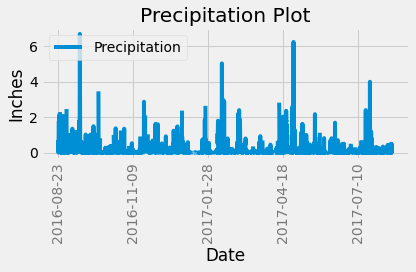

In [91]:
# Use Pandas Plotting with Matplotlib to plot the data
# Set x axis and tick locations
precipitation_pd.plot()
plt.xticks(rotation="vertical",alpha=0.5)

# Give our chart some labels and a tile

plt.title("Precipitation Plot")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.savefig("Images/avg_rain.png")
plt.show()

In [76]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_pd.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset

number_stations = session.query(func.count(station.id)).all()
number_stations

In [305]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

most_active_station = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [98]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temperature_most_active = [measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]

temperature_USC00519281 = session.query(*temperature_most_active).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
temperature_USC00519281

('USC00519281', 54.0, 85.0, 71.66378066378067)

In [99]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

data_query_temp = session.query(measurement.date, measurement.tobs).filter(measurement.station == 'USC00519281').\
                  filter(measurement.date >= query_date).order_by(measurement.date.desc()).all()
data_query_temp

[('2017-08-18', 79.0),
 ('2017-08-17', 76.0),
 ('2017-08-16', 76.0),
 ('2017-08-15', 77.0),
 ('2017-08-14', 77.0),
 ('2017-08-13', 77.0),
 ('2017-08-06', 83.0),
 ('2017-08-05', 82.0),
 ('2017-08-04', 77.0),
 ('2017-07-31', 76.0),
 ('2017-07-30', 81.0),
 ('2017-07-29', 82.0),
 ('2017-07-28', 81.0),
 ('2017-07-27', 76.0),
 ('2017-07-26', 75.0),
 ('2017-07-25', 77.0),
 ('2017-07-24', 75.0),
 ('2017-07-23', 82.0),
 ('2017-07-22', 77.0),
 ('2017-07-21', 77.0),
 ('2017-07-20', 77.0),
 ('2017-07-19', 76.0),
 ('2017-07-18', 76.0),
 ('2017-07-17', 76.0),
 ('2017-07-16', 80.0),
 ('2017-07-15', 80.0),
 ('2017-07-14', 76.0),
 ('2017-07-13', 74.0),
 ('2017-07-12', 74.0),
 ('2017-07-11', 72.0),
 ('2017-07-10', 69.0),
 ('2017-07-09', 78.0),
 ('2017-07-08', 78.0),
 ('2017-07-07', 75.0),
 ('2017-07-06', 74.0),
 ('2017-07-05', 77.0),
 ('2017-07-04', 78.0),
 ('2017-07-03', 76.0),
 ('2017-07-02', 81.0),
 ('2017-07-01', 79.0),
 ('2017-06-30', 76.0),
 ('2017-06-29', 76.0),
 ('2017-06-28', 77.0),
 ('2017-06-

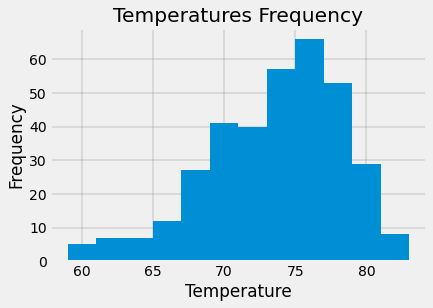

In [100]:
histo_df = pd.DataFrame(data_query_temp, columns=["Date", "temperature_most_active"])

plt.hist(histo_df["temperature_most_active"], bins=12)
plt.grid(color='grey', linestyle='-', linewidth=2, alpha=.2)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Temperatures Frequency")
plt.savefig("Images/Temperature Histogram")
plt.show()

# Close session

In [101]:
# Close Session
session.close()